In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

import myLib_barChart as myBar
import myLib_confMatrix as myMatrix
import myLib_parseData as myParse
import myLib_pieChart as myPie
import myLib_table as myTable
import myLib_testModel as myTest
from myLib_testModel import letterToSoftmax
import myLib_writeFile as myWrite
import myLib_debugFiles as myDebug


np.set_printoptions(suppress=True)

In [2]:
# DEfinition of string values for the bold print
S_BOLD = '\033[1m'
E_BOLD = '\033[0m'

# LOAD DATASET AND PREPARE TRAIN - TEST

In this section the functions loadDataFromTxt and parseTrainTest are called. These allow to load the dataset from the txt files into matrices and then separate them in smaller matrices for testing and training. 

In [3]:
vowels_data, vowels_label = myParse.loadDataFromTxt('vowels_OL')
OL_data_train_vow, OL_label_train_vow, OL_data_test_vow, OL_label_test_vow = myParse.parseTrainTest(vowels_data, vowels_label, 0.7)

******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (103600, 5)
Tot samples      -> 518


*** Separate train-valid

Train data shape  -> (361, 600)
Test data shape   -> (155, 600)


In [4]:
B_data, B_label = myParse.loadDataFromTxt('B_dataset')
B_train_data, B_train_label, B_test_data, B_test_label = myParse.parseTrainTest(B_data, B_label, 0.7)

******* Dataset for letter ['B']

Raw shape        -> (39400, 5)
Tot samples      -> 197


*** Separate train-valid

Train data shape  -> (136, 600)
Test data shape   -> (59, 600)


In [5]:
M_data, M_label = myParse.loadDataFromTxt('M_dataset')
M_train_data, M_train_label, M_test_data, M_test_label = myParse.parseTrainTest(M_data, M_label, 0.7)

******* Dataset for letter ['M']

Raw shape        -> (39000, 5)
Tot samples      -> 195


*** Separate train-valid

Train data shape  -> (135, 600)
Test data shape   -> (58, 600)


In [6]:
R_data, R_label = myParse.loadDataFromTxt('R_dataset')
R_train_data, R_train_label, R_test_data, R_test_label = myParse.parseTrainTest(R_data, R_label, 0.7)

******* Dataset for letter ['R']

Raw shape        -> (39000, 5)
Tot samples      -> 195


*** Separate train-valid

Train data shape  -> (135, 600)
Test data shape   -> (58, 600)


###  Create a dataset of all letters

In this smaller section all the previous matrices are stacked together and then shuffled in order to create two big matrices that contain all the letters for training and testing. The training dataset is also shuffled, in order to shuffle it differently change the seed value inside the function myParse.shuffleDataset

In [7]:
# Create a matrix that contains all the train data
data_all = OL_data_train_vow
data_all = np.vstack(( data_all, B_train_data))
data_all = np.vstack(( data_all, R_train_data))
data_all = np.vstack(( data_all, M_train_data))
# Create an array that contains all the train labels
label_all = OL_label_train_vow
label_all = np.hstack(( label_all, B_train_label))
label_all = np.hstack(( label_all, R_train_label))
label_all = np.hstack(( label_all, M_train_label))
# Shuffle the matrix and the label
data_all, label_all = myParse.shuffleDataset(data_all, label_all)

print('data_all has shape  ' + str(data_all.shape))
print('label_all has shape ' + str(label_all.shape))

data_all has shape  (767, 600)
label_all has shape (767,)


In [8]:
# Create a matrix that contains all the train data
data_test = OL_data_test_vow
data_test = np.vstack(( data_test, B_test_data))
data_test = np.vstack(( data_test, R_test_data))
data_test = np.vstack(( data_test, M_test_data))
# Create an array that contains all the train labels
label_test = OL_label_test_vow
label_test = np.hstack(( label_test, B_test_label))
label_test = np.hstack(( label_test, R_test_label))
label_test = np.hstack(( label_test, M_test_label))

print('data_test has shape  ' + str(data_test.shape))
print('label_test has shape ' + str(label_test.shape))

data_test has shape  (330, 600)
label_test has shape (330,)


Another method for loading the dataset is to load it from the txt file "training_file". This file is an already shuffled dataset. I can use this for both feeding data in this simulation and also to the STM in order to have the closes behaviour possible.

In [9]:
data, label = myParse.loadDataFromTxt('training_file')
data_train, label_train, data_test, label_test = myParse.parseTrainTest(data, label, 0.7)

******* Dataset for letter ['A' 'B' 'E' 'I' 'M' 'O' 'R' 'U']

Raw shape        -> (118600, 5)
Tot samples      -> 593


*** Separate train-valid

Train data shape  -> (413, 600)
Test data shape   -> (178, 600)


The class Data_Container is just a container that I created in order to have all the dataset in a single object. This is useful for the plotting functions because it allows me to give as input to the function just one object and not the entire list of datasets.

In [10]:
class Data_Container(object):
    def __init__(self):

        self.R_test_data       = R_test_data
        self.R_test_label      = R_test_label
        self.B_test_data       = B_test_data
        self.B_test_label      = B_test_label
        self.M_test_data       = M_test_data
        self.M_test_label      = M_test_label
        self.R_test_data       = R_test_data
        self.OL_data_test_vow  = OL_data_test_vow
        self.OL_label_test_vow = OL_label_test_vow
        
OL_testing_data = Data_Container()

### Check the content of the dataset

This block is used only to check the type of letters that are inside the datasets that I imported. It's used in order to see if the datasets are created and saved correctly.

In [11]:
print('VOWELS DATASET SANITY CHECK')
myParse.sanityCheckDataset(vowels_label)
print('\nB DATASET SANITY CHECK')
myParse.sanityCheckDataset(B_label)
print('\nR DATASET SANITY CHECK')
myParse.sanityCheckDataset(R_label)
print('\nM DATASET SANITY CHECK')
myParse.sanityCheckDataset(M_label)
print('\nTRAIN DATASET SANITY CHECK')
myParse.sanityCheckDataset(label_train)
print('\nTEST DATASET SANITY CHECK')
myParse.sanityCheckDataset(label_test)

VOWELS DATASET SANITY CHECK
    The letters found are:              ['O', 'U', 'A', 'E', 'I']
    And for each letter the counter is: [103. 103. 103. 103. 103.   1.   0.   0.   0.]

B DATASET SANITY CHECK
    The letters found are:              ['B']
    And for each letter the counter is: [194.   1.   0.   0.   0.   0.   0.   0.   0.]

R DATASET SANITY CHECK
    The letters found are:              ['R']
    And for each letter the counter is: [192.   1.   0.   0.   0.   0.   0.   0.   0.]

M DATASET SANITY CHECK
    The letters found are:              ['M']
    And for each letter the counter is: [192.   1.   0.   0.   0.   0.   0.   0.   0.]

TRAIN DATASET SANITY CHECK
    The letters found are:              ['R', 'A', 'E', 'U', 'O', 'B', 'M', 'I']
    And for each letter the counter is: [18. 76. 64. 76. 74. 20. 12. 72.  1.]

TEST DATASET SANITY CHECK
    The letters found are:              ['O', 'E', 'U', 'A', 'I', 'R', 'M', 'B']
    And for each letter the counter is: [28. 39. 27. 

#  ------------------------------------------------------------------------

# LOAD TF TRAINED MODEL

In this section I load the frozen model. The frozen model is the NN that has been trained with keras on the PC. The script that trains this model is called 'run_trainFroznModel.py'

In [12]:
ROOT_PATH = os.path.abspath('')
MODEL_PATH = ROOT_PATH + "/Saved_models/"

In [13]:
model = keras.models.load_model(MODEL_PATH + 'Original_model/model.h5')

#  ------------------------------------------------------------------------

# TINY OL

In this section the main part of the continual learning study is found. Here can be found the functions used for implementing the different algorithms. 

The function below is an implementation of the softmx function. I had to use this because I noticed that the sofmtax function used from keras and other methods for computing the sotmax operation gave different results.

In [14]:
def myFunc_softmax(array):
    """ Computes softmax of an array
    
    Parameters
    ----------
    array : array_like
        Is the array of which I want to compute the softmax operation
    """
    
    if(len(array.shape)==2):
        array = array[0]
        
    size    = len(array)
    ret_ary = np.zeros([len(array)])
    m       = array[0]
    sum_val = 0

    for i in range(0, size):
        if(m<array[i]):
            m = array[i]

    for i in range(0, size):
        sum_val += np.exp(array[i] - m)

    constant = m + np.log(sum_val)
    for i in range(0, size):
        ret_ary[i] = np.exp(array[i] - constant)
        
    return ret_ary


## TinyOL class

This class is just a container for all the informations that are required in order to use correctly a tinyOL model. The idea is to createa  container in which everything is stored and then simply change the method for the training.

In [15]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
        self.ML_frozen.compile()
        self.W = np.array(model.layers[-1].get_weights()[0])    # extract the weights from the last layer
        self.b = np.array(model.layers[-1].get_weights()[1])    # extract the biases from the last layer
        self.label = ['A', 'E', 'I', 'O', 'U']                  # the origina model knows only the vowels
        self.l_rate = 0                                         # learning rate that changes depending on the algorithm
        self.W_counter = np.zeros(self.W.shape)
        
        self.width = self.W.shape[0]        # shape of the weights matrix
        
        
        # Related to the results fo the model
        self.confusion_matrix = []          # container for the confusion matrix
        self.correct_ary = []               # array that contains the number of correct prediction for each letter
        self.mistake_ary = []               # array that contains the number of mistaken prediction for each letter
        self.totals_ary = []                # array that contains the number of total prediction for each letter
        
        self.macro_avrg_precision = 0       
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''       # title that will be displayed on plots
        self.filename = ''    # name of the files to be saved (plots, charts, conf matrix)
        
        
    # Function that is used for the prediction of the model saved in this class
    def predict(self, x):
        mat_prod = np.array(np.matmul(x, self.W) + self.b)
        return  myFunc_softmax(mat_prod) # othwerwise do it with keras|also remove np.array()| tf.nn.softmax(mat_prod) 

## TinyOL functions

This function is used in all methods before the feed forward of the OL layer. This function is required because it checks if the input letter is already known. If this is not true it will increse the dimension of the last layre (weight matrix and biases array) and also save the new letter in the 'known classes' array.

In [16]:
def checkLabelKnown(model, current_label):
    
    found = 0
    
    for i in range(0, len(model.label)):
        if(current_label == model.label[i]):
            found = 1
        
        
    # If the label is not known
    if(found==0):
        print(f'\n\n    New letter detected -> letter \033[1m{current_label}\033[0m \n')

        model.label.append(current_label)   # Add new letter to label
        
        # Increase weights and biases dimensions
        model.W = np.hstack((model.W, np.zeros([model.width,1])))
        model.b = np.hstack((model.b, np.zeros([1])))
        
        model.W_counter = np.hstack((model.W_counter, np.zeros((model.width,1))))


From here the functions that implement the different methods can be found. The explanation of the code od these function is not here but it can be found in the paper "Continuous learning in single incremental taskscenarios" and some schemes can be found in my presentation.

### OL

In [17]:
numb = data_train.shape[0]

frozenOut_pc  = np.zeros((numb, 128))
weight_pc     = np.zeros((numb, 80))
bias_pc       = np.zeros((numb,8))
preSoftmax_pc = np.zeros((numb,8))
softmax_pc    = np.zeros((numb,8))

weight_letter_b = np.zeros((128, numb))



selected_w = [46,13,107,3,57,65,127,81,89,70,
                143,239,142,158,207,189,172,230,156,208,
                374,359,375,371,303,298,350,257,349,333,
                402,502,485,461,489,479,454,508,485,480,
                527,565,614,517,528,613,625,623,587,521,
                712,742,685,746,759,747,754,702,653,640,
                775,809,798,853,804,840,828,788,890,819,
                906,1019,911,1005,1016,953,1016,987,961,1023]

In [18]:
def trainOneEpoch_OL(model, x, y_true):
    
    print('**********************************\nPerforming training with OL METHOD - STOCHASTICH\n')
   
    cntr = 1
    learn_rate  = model.l_rate
    tot_samples = x.shape[0]
                
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label)
               
        # PPREDICTION
        y_ML   = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])           
        
        temp = np.copy(np.array(np.matmul(y_ML, model.W) + model.b))
        temp = temp[0]
        
        # BACKPROPAGATION
        cost = y_pred-y_true_soft
        
        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW     = np.multiply(deltaW, learn_rate)
            model.W_counter[j,:] += dW
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db      = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        
        
        
        # TO BE REMOVED LATER **********
        # SAVE THE WEIGHTS IN A MATRIX
        if(i<numb):
            
            frozenOut_pc[i,:] = y_ML[0,:]
                    
            for q in range(0, 8):
                if(q<model.W.shape[1]):
                    bias_pc[i,q]       = np.copy(model.b[q])
                    softmax_pc[i,q]    = np.copy(y_pred[q])
                    preSoftmax_pc[i,q] = np.copy(temp[q])

            for q in range(0, 80):
                if(int(selected_w[q]/128) < model.W.shape[1] ):
                    weight_pc[i,q] = np.copy(model.W[selected_w[q]%128, int(selected_w[q]/128)])
        # *********************************

        
        
        
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL MINI BATCH

In [19]:
def trainOneEpoch_OL_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with OL METHOD - MINI BATCH\n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
            
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label)        
                
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        if(i%batch_size==0):
                model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
                model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]

                sum_gradW = np.zeros([h, 8])  #reset each batch  
                sum_gradB = np.zeros([1, 8])  #reset each batch   
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft

        for j in range(0,h): 
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:w] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:w] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2

In [20]:
  def trainOneEpoch_OL_v2(model, x, y_true):
    
    print('**********************************\nPerforming training with CWR METHOD - STOCASTICH \n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
                
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft
        cost[0] = 0
        cost[1] = 0
        cost[2] = 0
        cost[3] = 0

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW[:]

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b[5:] = model.b[5:]-db[5:]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2 MINI BATCH

In [21]:
def trainOneEpoch_OL_v2_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with CWR - MINI BATCH \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # If beginning of batch
        if(i%batch_size==0):
                model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
                model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
                sum_gradW = np.zeros([h, 8])  # reset
                sum_gradB = np.zeros([1, 8])  # reset
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft

        for j in range(0,h):  
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:tmp.shape[0]] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:cost.shape[0]] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
            model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF

In [22]:
def trainOneEpochOL_LWF(model, x, y_true):
    
    print('**********************************\nPerforming training with LWF - STOCHASTIC\n ') 
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    y_LWF = np.zeros([1, 8])    # Define container for LWF

    # DEFINE ORIGINAL WEIGHTS AND BIASES
    LWF_w = model.W
    LWF_b = model.b
         
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                
        w = model.W.shape[1]
        h = model.W.shape[0]
        
        # va da 1 a 0
        lam = 100/(100+cntr)    #1-i/493    #  1/(20+cntr)        #
             
        # PREDICTIONS
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])
        
        mat_prod = np.array(np.matmul(y_ML, LWF_w) + LWF_b)
        y_LWF[0,:5] = my_Softmax(mat_prod)   
          
        
        # BACKPROPAGATION        
        cost_norm = y_pred-y_true_soft
        cost_LWF  = y_pred-y_LWF[0,:w]

        for j in range(0,h):
            # Update weights
            deltaW_norm = np.multiply(cost_norm,1-lam)
            deltaW_LWF  = np.multiply(cost_LWF, lam)
            deltaW      = np.multiply(deltaW_norm+deltaW_LWF, y_ML[0,j])
            dW          = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db_norm = np.multiply(cost_norm, 1-lam)
        db_LWF  = np.multiply(cost_LWF, lam)
        db      = np.multiply(db_norm+db_LWF, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF MINI BATCH

In [23]:
def trainOneEpochOL_LWF_v2(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with LWF - MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
        
    w = model.W.shape[1]
        
    LWF_w = np.zeros([model.W.shape[0], 8]) # alocate
    LWF_b = np.zeros([1, 8]) 
    y_LWF = np.zeros([1, 8])
    
    LWF_w[:,:w] = model.W   # copy from TF
    LWF_b[0,:w] = model.b
    
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # END OF BATCH
        if(i%batch_size==0 and i!=0):            
            LWF_w[:,:w] = np.copy(model.W)    # update the LWF w matrix
            LWF_b[0,:w] = np.copy(model.b)    # update the LWF b matrix
                
        #lam = 1/(2+cntr)
        if(cntr<batch_size):
            lam = 1
        else:
            lam = batch_size/cntr  #(cntr/493)   va da 0 a 1
    
        # PREDICTION - Frozen + OL
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])  
        
        mat_prod = np.array(np.matmul(y_ML, LWF_w[:,:w]) + LWF_b[0,:w])
        y_LWF[0,:w] = my_Softmax(mat_prod)        


         
        # ---- BACKPROPAGATION | MINI BATCH + LWF        
        cost_norm = y_pred-y_true_soft
        cost_LWF  = y_pred-y_LWF[0,:w]
        
        lam_cost_norm = np.multiply(cost_norm, 1-lam)
        lam_cost_LWF  = np.multiply(cost_LWF,  lam)

        for j in range(0,h):

            # Update weights
            deltaW = np.multiply(lam_cost_norm+lam_cost_LWF, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW          
            
        # Update biases 
        db = np.multiply(lam_cost_norm+lam_cost_LWF, learn_rate)
        model.b = model.b-db   
                        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### CWR

In [24]:
def trainOneEpoch_CWR(model, x, y_true, batch_size):
        
    print('**********************************\nPerforming training CWR \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    TW = np.zeros([model.W.shape[0], 8])
    TB = np.zeros([1, 8])
    found_lett = np.zeros([1,8])
               
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        current_label = y_true[i]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
        
        h = model.W.shape[0]
        w = model.W.shape[1]
                
        # If beginning of batch
        if(i%batch_size==0 and i!=0): 
            for k in range(0, w):
                if(found_lett[0,k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
                    
            TW[:h,:w]  = np.copy(model.W)
            TB[0,:w]   = np.copy(model.b)
            found_lett = np.zeros([1,8])  # reset
        elif(i==0):
            TW = np.zeros([h, 8])         # reset  
            TB = np.zeros([1, 8])         # reset  
            found_lett = np.zeros([1,8])  # reset
                
        found_lett[0,np.argmax(y_true_soft[i,:])] += 1  # update the letter counter
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        mat_prod = np.array(np.matmul(y_ML, TW) + TB)
        y_pred = my_Softmax(mat_prod)        


        # BACKPROPAGATION
        cost = y_pred[:w]-y_true_soft

        # Update weights
        for j in range(0,h):
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            TW[j,:w] = TW[j,:w] - dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        TB[0,:w] = TB[0,:w]-db

        # If last iteration
        if(i==tot_samples-1):
            for k in range(5, w):
                if(found_lett[0,k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1
        

# Trainings

Now let's dfine some important values for the training and then actually train each single OL layer witha  different method. The 0 and 1 below are used in order to activate or deactivate the training and the following plots of a specific method.

In [25]:
batch_size_OL = 8

In [26]:
# DEFINE WHICH TRAINING AND PLOTS TO SHOW

KERAS      = 1
OL_vowels  = 0
OL         = 1
OL_mini    = 0
LWF        = 0
LWF_mini   = 0
OL_v2      = 0
OL_v2_mini = 0
CWR        = 0

### Define KERAS model (just create the class, actually don't train)

In [27]:
if(KERAS==1):
    Model_KERAS = Custom_Layer(model)
    Model_KERAS.title = 'KERAS'
    Model_KERAS.filename = 'KERAS'
    Model_KERAS.label = ['A','E','I','O','U','B','R','M']
    # DO NOT PERFORM TRAINING, KEEP IT AS IT IS, IT'S THE ORIGINAL MODEL

### Train with OL only on vowels (just to see if the OL model makes the keras better or worse)

In [28]:
if(OL_vowels==1):
    Model_OL_vowels = Custom_Layer(model)
    Model_OL_vowels.title = 'VOWELS'
    Model_OL_vowels.filename = 'OL_vowels'
    Model_OL_vowels.l_rate = 0.000005
    
    trainOneEpoch_OL(Model_OL_vowels, OL_data_train_vow, OL_label_train_vow)

### Train with OL method

In [29]:
if(OL==1):
    Model_OL_all_mixed = Custom_Layer(model)
    Model_OL_all_mixed.title = 'OL' 
    Model_OL_all_mixed.filename = 'OL'
    Model_OL_all_mixed.l_rate = 0.00005 # 0.000005 true value jupyter

    trainOneEpoch_OL(Model_OL_all_mixed, data_train, label_train)

**********************************
Performing training with OL METHOD - STOCHASTICH



    New letter detected -> letter R 

    Currently at 1.94% of dataset

    New letter detected -> letter B 

    Currently at 2.18% of dataset

    New letter detected -> letter M 

    Currently at 100.0% of dataset

## DEBUG

Load weights, biases and the out of frozen layer from txt file

In [30]:
bias_stm      = myDebug.debug_loadBiasSMT()
weight_stm    = myDebug.debug_loadWeightsSTM()
frozenOut_stm = myDebug.debug_loadFrozenOutSMT()
softmax_stm   = myDebug.debug_loadSoftmaxSMT()
preSoftmax_stm= myDebug.debug_loadPreSoftmaxSMT()

max_dim = data_train.shape[0]

### TEST

dato che alla prima iterazione l'output della lettera B è gia diverso da 0 c'è qualcosa di sbagliato nei weight di B

In [31]:
Model_KERAS.W[:,0]

array([-0.16797458,  0.09340061, -0.12994279,  0.08135014,  0.05181012,
       -0.15629308,  0.0974269 , -0.09650051,  0.02936678,  0.02749925,
       -0.08022589,  0.08050191,  0.03860217,  0.06409207, -0.03654132,
        0.09062052,  0.03280481,  0.2062422 ,  0.19704545, -0.07537907,
       -0.17857014, -0.06055346,  0.15006788, -0.16542993,  0.20742546,
        0.10019736,  0.0612965 ,  0.21646258,  0.08298391, -0.19707346,
        0.04516099, -0.08520682,  0.01067171,  0.14694397, -0.18346429,
        0.07694482, -0.08970557,  0.13542822,  0.16079116, -0.03216502,
        0.16457382,  0.11402351,  0.16936693, -0.0558387 ,  0.0220503 ,
       -0.13077392, -0.1380975 , -0.17192295, -0.16496132,  0.1361559 ,
       -0.02622787, -0.0648715 , -0.11655258, -0.16735479, -0.12536673,
        0.17501959, -0.07166758,  0.21202117,  0.0474488 , -0.16401133,
        0.19223617,  0.14292823, -0.12064658,  0.01107887,  0.06141135,
       -0.16783923, -0.12568973,  0.10136129,  0.14523159, -0.10

In [32]:
weight_stm[0,65]

2.147483647

labels is: O
The max difference is 0.00012008398437046708


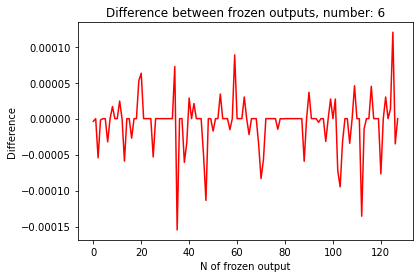

bias pc  -0.0076340 -0.0010334 0.0029947 0.0022518 0.0014424 -0.0000000 0.0000000 0.0000000
bias stm -0.0076340 -0.0010334 0.0029947 0.0022518 0.0014424 0.0000000 0.0000000 0.0000000

weight pc  -0.1678392 0.0922456 0.0209722 0.1877925 -0.1765726 0.0148541 0.0000000 0.0000000
weight stm -0.1678392 0.0922456 0.0209722 0.1877925 -0.1765726 0.0148541 2.1474836 0.0000000

pre softmax pc  -205.8505902 87.3946532 -350.6870349 615.4898864 184.6315142 -31.4416874 0.0000000 0.0000000
pre softmax stm -205.8505760 87.3946480 -350.6870720 615.4898560 184.6313920 -31.4416940 0.0000000 0.0000000

softmax pc  0.0000000 0.0000000 0.0000000 1.0000000 0.0000000 0.0000000 0.0000000 0.0000000
softmax stm 0.0000000 0.0000000 0.0000000 1.0000000 0.0000000 0.0000000 0.0000000 0.0000000


In [33]:
test_n = 6

print(f'labels is: {label_train[test_n]}')
myDebug.plot_frozenDifference(test_n, frozenOut_pc, frozenOut_stm)
print(f'bias pc  {bias_pc[test_n,0]:.7f} {bias_pc[test_n,1]:.7f} {bias_pc[test_n,2]:.7f} {bias_pc[test_n,3]:.7f} {bias_pc[test_n,4]:.7f} {bias_pc[test_n,5]:.7f} {bias_pc[test_n,6]:.7f} {bias_pc[test_n,7]:.7f}')
print(f'bias stm {bias_stm[test_n,0]:.7f} {bias_stm[test_n,1]:.7f} {bias_stm[test_n,2]:.7f} {bias_stm[test_n,3]:.7f} {bias_stm[test_n,4]:.7f} {bias_stm[test_n,5]:.7f} {bias_stm[test_n,6]:.7f} {bias_stm[test_n,7]:.7f}')
print()
print(f'weight pc  {weight_pc[test_n,5]:.7f} {weight_pc[test_n,15]:.7f} {weight_pc[test_n,25]:.7f} {weight_pc[test_n,35]:.7f} {weight_pc[test_n,45]:.7f} {weight_pc[test_n,55]:.7f} {weight_pc[test_n,65]:.7f} {weight_pc[test_n,75]:.7f}')
print(f'weight stm {weight_stm[test_n,5]:.7f} {weight_stm[test_n,15]:.7f} {weight_stm[test_n,25]:.7f} {weight_stm[test_n,35]:.7f} {weight_stm[test_n,45]:.7f} {weight_stm[test_n,55]:.7f} {weight_stm[test_n,65]:.7f} {weight_stm[test_n,75]:.7f}')
print()
print(f'pre softmax pc  {preSoftmax_pc[test_n,0]:.7f} {preSoftmax_pc[test_n,1]:.7f} {preSoftmax_pc[test_n,2]:.7f} {preSoftmax_pc[test_n,3]:.7f} {preSoftmax_pc[test_n,4]:.7f} {preSoftmax_pc[test_n,5]:.7f} {preSoftmax_pc[test_n,6]:.7f} {preSoftmax_pc[test_n,7]:.7f}')
print(f'pre softmax stm {preSoftmax_stm[test_n,0]:.7f} {preSoftmax_stm[test_n,1]:.7f} {preSoftmax_stm[test_n,2]:.7f} {preSoftmax_stm[test_n,3]:.7f} {preSoftmax_stm[test_n,4]:.7f} {preSoftmax_stm[test_n,5]:.7f} {preSoftmax_stm[test_n,6]:.7f} {preSoftmax_stm[test_n,7]:.7f}')
print()
print(f'softmax pc  {softmax_pc[test_n,0]:.7f} {softmax_pc[test_n,1]:.7f} {softmax_pc[test_n,2]:.7f} {softmax_pc[test_n,3]:.7f} {softmax_pc[test_n,4]:.7f} {softmax_pc[test_n,5]:.7f} {softmax_pc[test_n,6]:.7f} {softmax_pc[test_n,7]:.7f}')
print(f'softmax stm {softmax_stm[test_n,0]:.7f} {softmax_stm[test_n,1]:.7f} {softmax_stm[test_n,2]:.7f} {softmax_stm[test_n,3]:.7f} {softmax_stm[test_n,4]:.7f} {softmax_stm[test_n,5]:.7f} {softmax_stm[test_n,6]:.7f} {softmax_stm[test_n,7]:.7f}')

In [34]:
# search where is the first big difference
iteratore = np.zeros(8)
for j in range(0,8):
    for i in range(0, max_dim):
        diff = preSoftmax_pc[i,j] - preSoftmax_stm[i,j]
        if(diff>1):
            iteratore[j]=i
            break
        
print(f'The big difference in the pre softmax is found at iter: {iteratore}')

The big difference in the pre softmax is found at iter: [156. 383.   0.   0.   0. 297.   0. 331.]


In [35]:
# search where is the first big difference
iteratore = np.zeros(8)
for j in range(0,8):
    for i in range(0, max_dim):
        diff = softmax_pc[i,j] - softmax_stm[i,j]
        if(diff>0.0001):
            iteratore[j]=i
            break
        
print(f'The big difference in the softmax is found at iter:     {iteratore}')

The big difference in the softmax is found at iter:     [296. 275. 400.   0.   0. 110.   0. 155.]


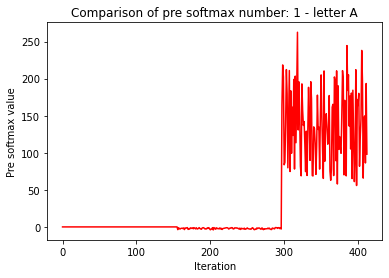

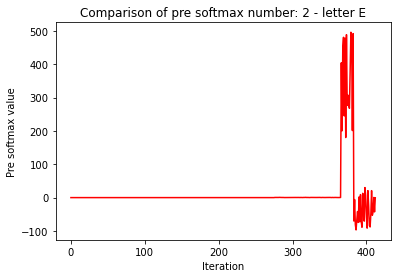

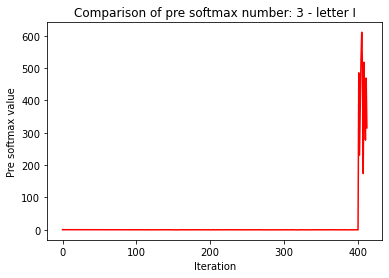

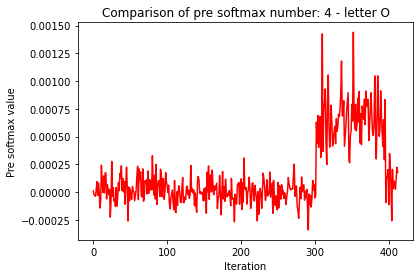

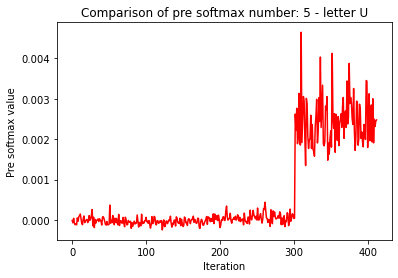

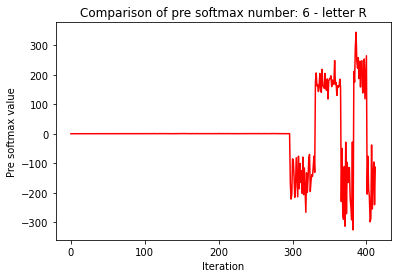

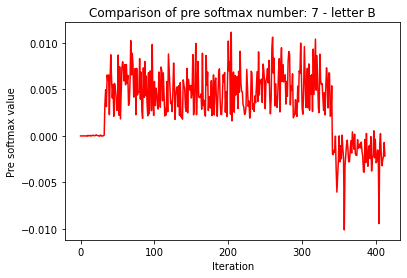

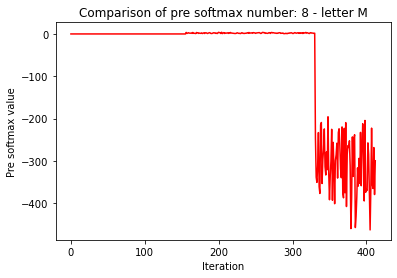

In [36]:
myDebug.debug_plotHistoryPreSoftmax(0, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(1, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(2, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(3, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(4, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(5, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(6, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryPreSoftmax(7, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)

### Confront SOFTMAX

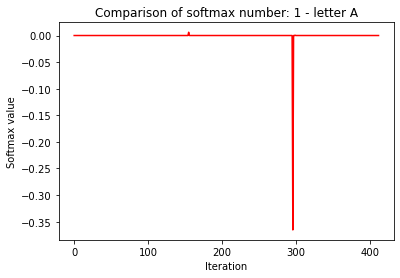

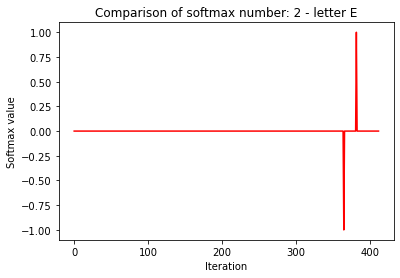

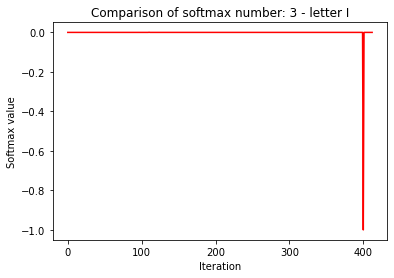

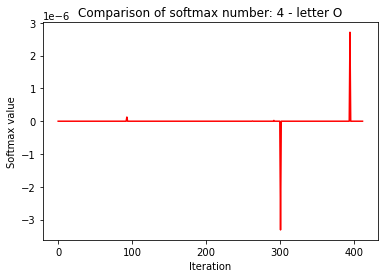

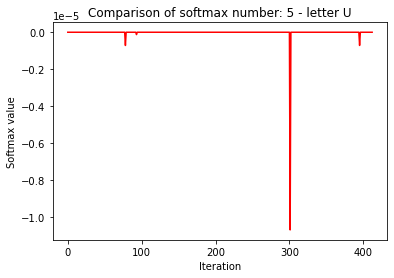

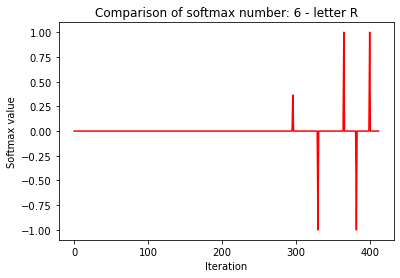

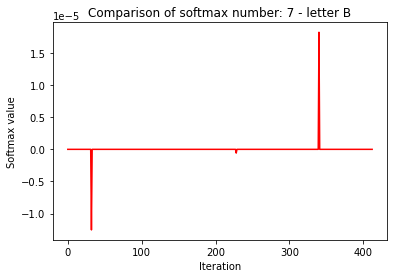

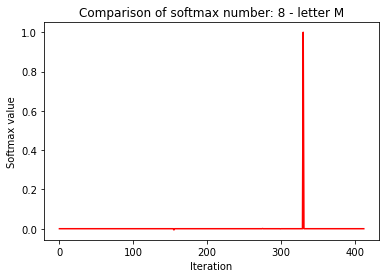

In [37]:
myDebug.debug_plotHistorySoftmax(0, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(1, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(2, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(3, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(4, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(5, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(6, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistorySoftmax(7, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)

### Confront BIASES

In [38]:
n_prova = max_dim-1
myDebug.debug_confrontBias(n_prova, bias_stm, bias_pc, Model_OL_all_mixed.label) # max 771

print(f'correct label is: {label_train[n_prova]}')
for i in range (0, len(Model_OL_all_mixed.label)):
    print(f'    label: {Model_OL_all_mixed.label[i]}   pred: {softmax_pc[n_prova,i]:.11f}   pre soft: {preSoftmax_pc[n_prova,i]:.10f}' )

Iteration number 412
n bias     vowel
  0          A             -0.00766858303       PC
                           -0.00765064700       STM
                            0.00001793603       difference 

  1          E             -0.00100123888       PC
                           -0.00100119000       STM
                            0.00000004888       difference 

  2          I              0.00303934044       PC
                            0.00308930100       STM
                            0.00004996056       difference 

  3          O              0.00229570689       PC
                            0.00229570700       STM
                            0.00000000011       difference 

  4          U              0.00149850389       PC
                            0.00149850400       STM
                            0.00000000011       difference 

  5          R              0.00007492511       PC
                            0.00005669000       STM
                           -0.000018235

In [39]:
print(bias_stm[100,5]-bias_pc[100,5])

-8.853649051683881e-10


The final values are:
          PC:-0.00766858303
         STM:-0.00765064700
  difference:-0.00001793603  - which is 0.0023443813085340277%


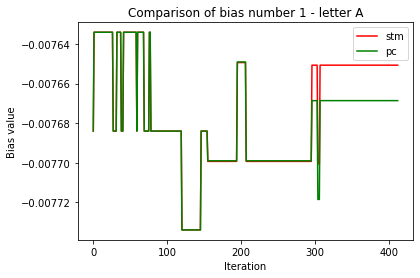

The final values are:
          PC:-0.00100123888
         STM:-0.00100119000
  difference:-0.00000004888  - which is 4.88185971255751e-05%


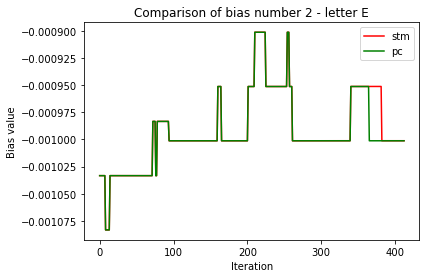

The final values are:
          PC:0.00303934044
         STM:0.00308930100
  difference:-0.00004996056  - which is 0.01617212395844443%


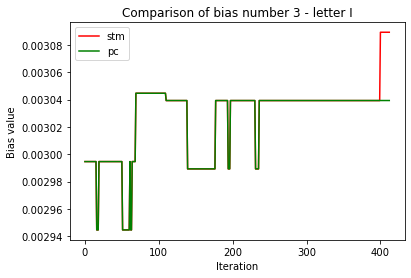

The final values are:
          PC:0.00229570689
         STM:0.00229570700
  difference:-0.00000000011  - which is 4.8919912020023e-08%


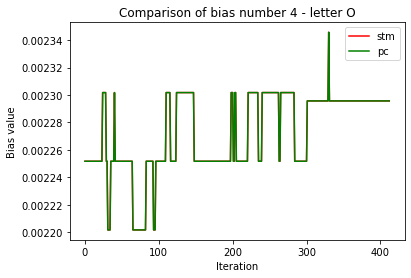

The final values are:
          PC:0.00149850389
         STM:0.00149850400
  difference:-0.00000000011  - which is 7.114023278446092e-08%


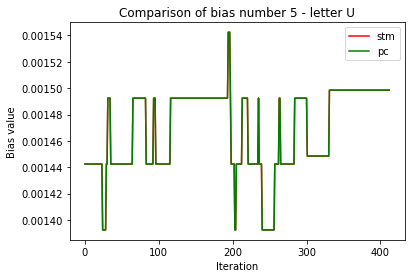

The final values are:
          PC:0.00007492511
         STM:0.00005669000
  difference:0.00001823511  - which is 0.24337778214848624%


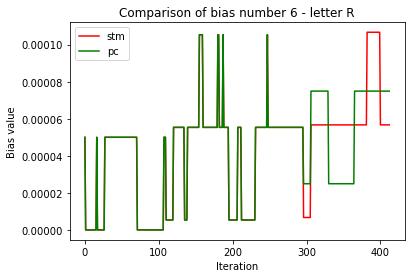

The final values are:
          PC:-0.00024999514
         STM:-0.00024999500
  difference:-0.00000000014  - which is 5.790363201232492e-07%


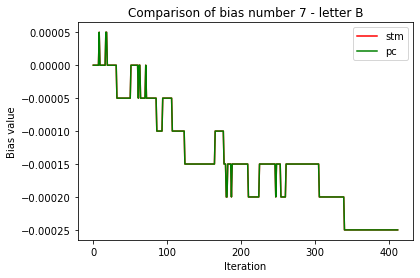

The final values are:
          PC:0.00003285442
         STM:-0.00001685700
  difference:0.00004971142  - which is 1.5130817110907708%


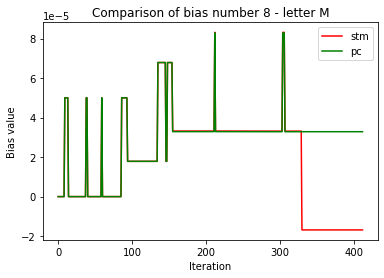

In [40]:
myDebug.debug_plotHistoryBias(0, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(1, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(2, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(3, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(4, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(5, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(6, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
myDebug.debug_plotHistoryBias(7, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)

### Confront weights

In [41]:
weight_num  = list(range(60,70))

In [42]:
n_prova = max_dim-1

myDebug.debug_confrontWeights(n_prova, weight_stm, weight_pc, weight_num, selected_w)

Iteration number 412
n weight
  775             -0.01529217997       PC
                 -0.01529218600       STM
                 -0.00000000603       difference 

  809             -0.00961266447       PC
                 -0.00961267000       STM
                 -0.00000000553       difference 

  798              0.05713060023       PC
                  0.05713089600       STM
                  0.00000029577       difference 

  853              0.12762936380       PC
                  0.12762953600       STM
                  0.00000017220       difference 

  804             -0.02693859386       PC
                 -0.02693902800       STM
                 -0.00000043414       difference 

  840              0.05567856847       PC
                  0.05567792800       STM
                 -0.00000064047       difference 

  828             -0.10331396485       PC
                 -0.10331394400       STM
                  0.00000002085       difference 

  788             -0.0382

The final values are:
             PC:-0.11519304693
            STM:-0.11518423200
  difference:-0.00000881493  - which is 7.652900197511212e-05%


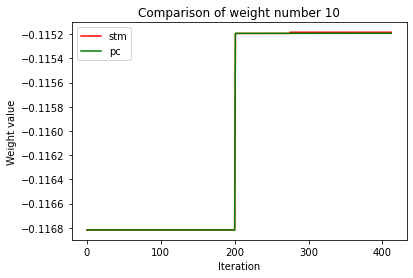

The final values are:
             PC:-0.16783922911
            STM:-0.16783923200
  difference:0.00000000289  - which is 1.723731063402577e-08%


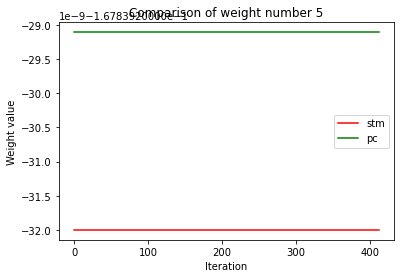

The final values are:
             PC:-0.14595808089
            STM:-0.14595808000
  difference:-0.00000000089  - which is 6.082530714148952e-09%


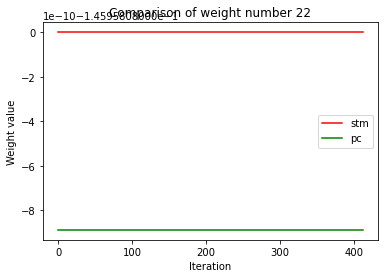

The final values are:
             PC:-0.02050341995
            STM:-0.02050979000
  difference:0.00000637005  - which is 0.00031068219063647384%


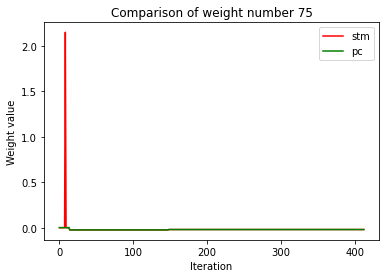

The final values are:
             PC:-0.10331396485
            STM:-0.10331394400
  difference:-0.00000002085  - which is 2.0183396084262284e-07%


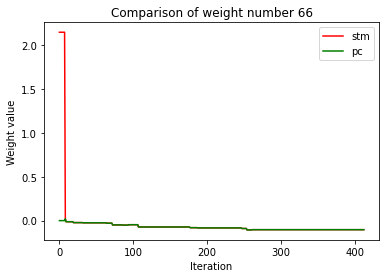

The final values are:
             PC:-0.16194359725
            STM:-0.16194358400
  difference:-0.00000001325  - which is 8.182197159002694e-08%


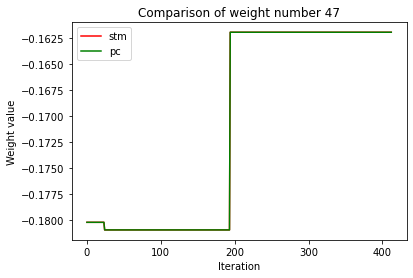

The final values are:
             PC:-0.19733485579
            STM:-0.19733484800
  difference:-0.00000000779  - which is 3.950091272815132e-08%


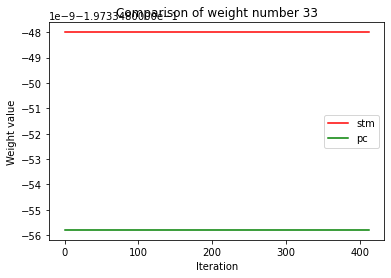

The final values are:
             PC:-0.02693859386
            STM:-0.02693902800
  difference:0.00000043414  - which is 1.6116043090925565e-05%


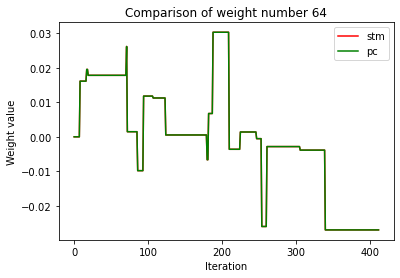

The final values are:
             PC:-0.00000000000
            STM:0.00000000000
  difference:-0.00000000000  - which is inf%


C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_debugFiles.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  if(diff/max_val > 0.05):
C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_debugFiles.py:101: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'  difference:{col_FAIL}{(weight_pc[max_dim-1,weight_num]-weight_stm[max_dim-1,weight_num]):.11f}{col_RESET}  - which is {diff/max_val}%')


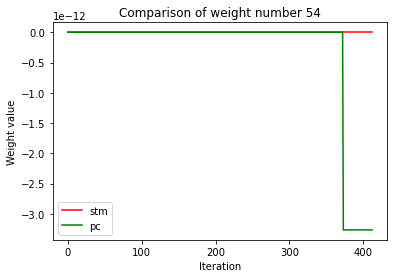

The final values are:
             PC:0.00000000000
            STM:0.00000000000
  difference:0.00000000000  - which is nan%


C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_debugFiles.py:100: RuntimeWarning: invalid value encountered in double_scalars
  if(diff/max_val > 0.05):
C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_debugFiles.py:103: RuntimeWarning: invalid value encountered in double_scalars
  print(f'  difference:{col_OK}{(weight_pc[max_dim-1,weight_num]-weight_stm[max_dim-1,weight_num]):.11f}{col_RESET}  - which is {diff/max_val}%')


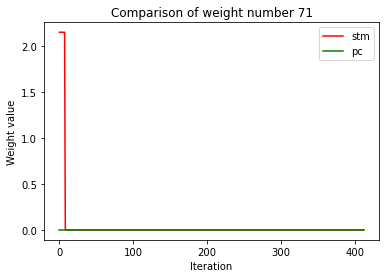

The final values are:
             PC:-0.05147843069
            STM:-0.05147822800
  difference:-0.00000020269  - which is 3.937306365542511e-06%


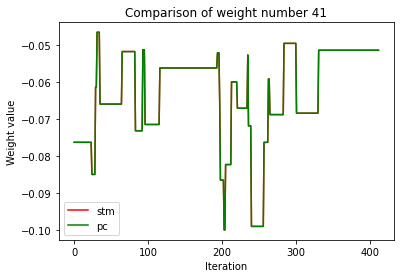

The final values are:
             PC:-0.02891096015
            STM:-0.02891754400
  difference:0.00000658385  - which is 0.00022772860499558608%


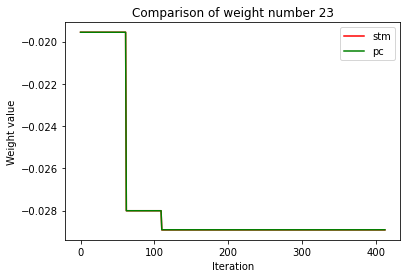

The final values are:
             PC:0.18788572735
            STM:0.18788572800
  difference:-0.00000000065  - which is 3.449416215398544e-09%


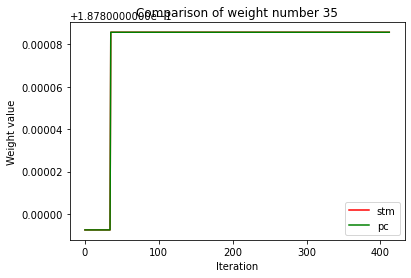

In [43]:
myDebug.debug_plotHistoryWeight(10, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(5, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(22, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(75, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(66, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(47, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(33, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(64, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(54, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(71, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(41, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(23, weight_stm, weight_pc, max_dim)
myDebug.debug_plotHistoryWeight(35, weight_stm, weight_pc, max_dim)

### FROZEN OUTPUT

In [44]:
max_val = 0
itr_1   = 0
itr_2   = 0
for i in range(0,max_dim):
    diff = frozenOut_pc[i,:] - frozenOut_stm[i,:]
    for j in range(0, len(diff)):
        diff[j] = np.abs(diff[j])
    if(max(diff)> max_val):
        max_val = max(diff)
        itr_1 = i
        itr_2 = np.argmax(diff)
        
print(f'The max values of difference of all {frozenOut_stm.shape[0]} iteration is: {S_BOLD}{max_val:.11f}{E_BOLD}')
print(f'The max difference is found at the iteration number: {S_BOLD}{itr_1}{E_BOLD}')
print(f'At the position in the frozen output: {S_BOLD}{itr_2}/128{E_BOLD}')

The max values of difference of all 413 iteration is: 0.00053227344
The max difference is found at the iteration number: 94
At the position in the frozen output: 101/128


The max difference is 0.0002479140624700449


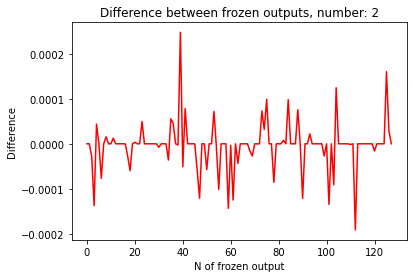

In [45]:
myDebug.plot_frozenDifference(2, frozenOut_pc, frozenOut_stm)

In [46]:
new_container = np.zeros(frozenOut_stm.shape)

for j in range(0, frozenOut_stm.shape[0]):
    for i in range(0, frozenOut_stm.shape[1]):
        max_val = max(frozenOut_pc[j,i], frozenOut_pc[j,i])
        if(max_val != 0):
            diff = frozenOut_pc[j,i]-frozenOut_stm[j,i]
            new_container[j,i] = diff/max_val
          
        
max_val =0
for j in range(0, frozenOut_stm.shape[0]):
    if(max_val < max(new_container[i,:])):
        max_val = max(new_container[i,:])
        
print(f'The max percentage error committed between stm and laptop is of: {max_val:.11f}')
print(f'Percentage at position, 237, 79 is {new_container[237,79]}')

The max percentage error committed between stm and laptop is of: 0.00002041353
Percentage at position, 237, 79 is 0.0


## END DEBUG *********************************************

### Train with OL + mini batch

In [47]:
if(OL_mini==1):
    Model_OL_mini = Custom_Layer(model)
    Model_OL_mini.title = 'OL + mini batch'
    Model_OL_mini.filename = 'OL_batches'
    Model_OL_mini.l_rate = 0.0001

    trainOneEpoch_OL_miniBatch(Model_OL_mini, data_train, label_train, batch_size_OL)

### Train with LWF

In [48]:
if(LWF==1):
    Model_LWF_1 = Custom_Layer(model)
    Model_LWF_1.title = 'LWF'
    Model_LWF_1.filename = 'LWF'   
    Model_LWF_1.l_rate = 0.0017 #0.001

    trainOneEpochOL_LWF(Model_LWF_1, data_train, label_train)   

### Train LWF + mini batches

In [49]:
if(LWF_mini==1):
    Model_LWF_2 = Custom_Layer(model)
    Model_LWF_2.title = 'LWF + mini batch'
    Model_LWF_2.filename = 'LWF_batches'
    Model_LWF_2.l_rate = 0.000001

    trainOneEpochOL_LWF_v2(Model_LWF_2, data_train, label_train, batch_size_OL)

### Train with OL v2 

In [50]:
if(OL_v2==1):
    Model_OL_v2 = Custom_Layer(model)
    Model_OL_v2.title = 'OL v2' 
    Model_OL_v2.filename = 'OL_v2'
    Model_OL_v2.l_rate = 0.00005

    trainOneEpoch_OL_v2(Model_OL_v2, data_train, label_train)

### Train with OL v2 + mini batch

In [51]:
if(OL_v2_mini==1):
    Model_OL_v2_miniBatch = Custom_Layer(model)
    Model_OL_v2_miniBatch.title = 'OL v2 + mini batch'
    Model_OL_v2_miniBatch.filename = 'OL_v2_batches'
    Model_OL_v2_miniBatch.l_rate = 0.001

    trainOneEpoch_OL_v2_miniBatch(Model_OL_v2_miniBatch, data_train, label_train, batch_size_OL)

### Train with CWR

In [52]:
if(CWR==1):
    Model_CWR = Custom_Layer(model) 
    Model_CWR.title = 'CWR'
    Model_CWR.filename = 'CWR'
    Model_CWR.l_rate = 0.0009   # 0.00005

    trainOneEpoch_CWR(Model_CWR, data_train, label_train, batch_size_OL)

# SIMULATION PLOTS

### KERAS model

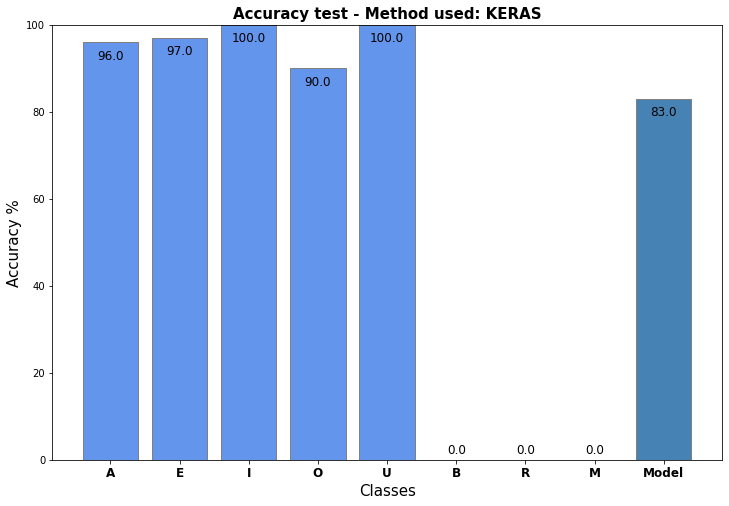

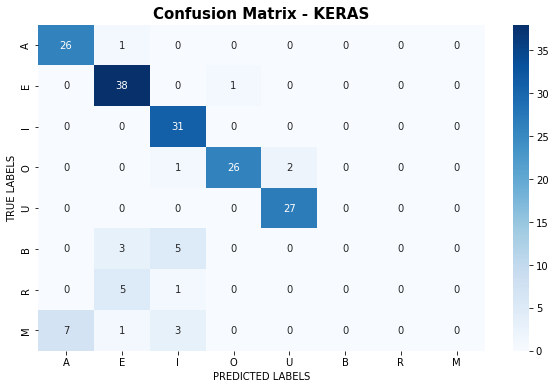

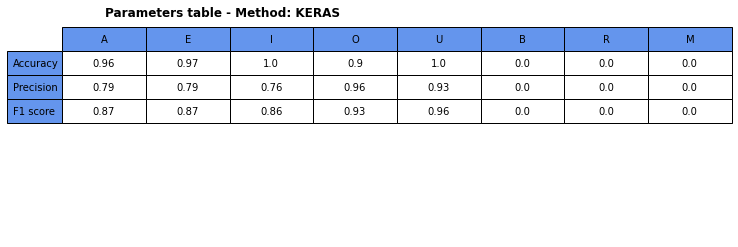

In [53]:
if(KERAS==1):
    myTest.test_OLlayer(Model_KERAS, data_test, label_test)
    myBar.plot_barChart(Model_KERAS)   
    myMatrix.plot_confMatrix(Model_KERAS)
    myTable.table_params(Model_KERAS)

### Only vowels

In [54]:
if(OL_vowels==1):
    myTest.test_OLlayer(Model_OL_vowels, data_test, label_test)
    myBar.plot_barChart(Model_OL_vowels)
    myMatrix.plot_confMatrix(Model_OL_vowels)
    myTable.table_params(Model_OL_vowels)

### OL

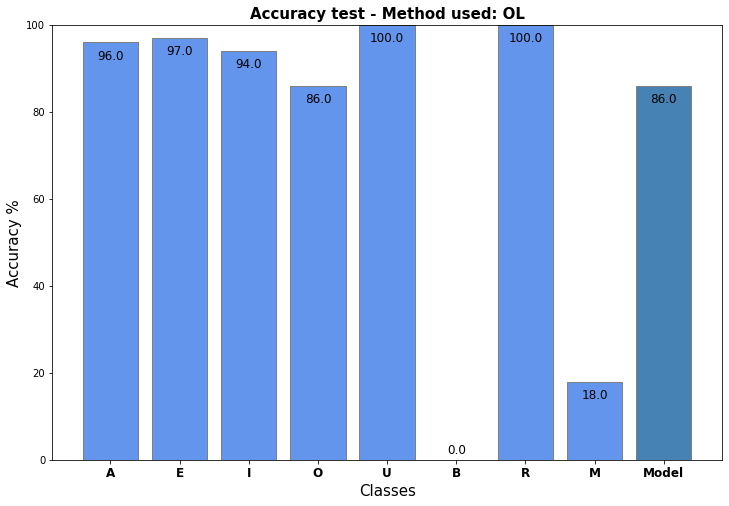

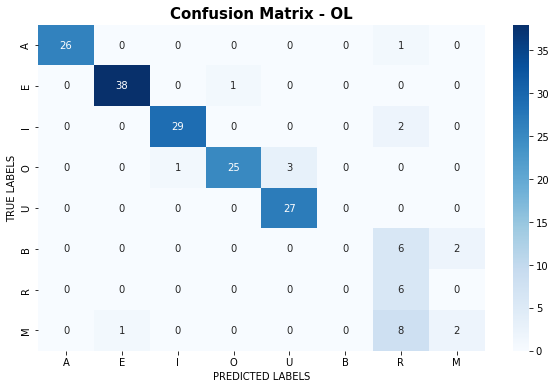

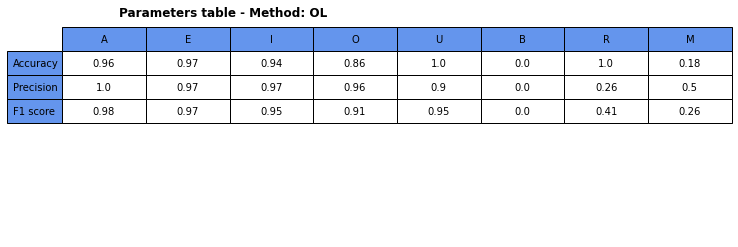

In [55]:
if(OL==1):
    myTest.test_OLlayer(Model_OL_all_mixed, data_test, label_test)
    myBar.plot_barChart(Model_OL_all_mixed)
    myMatrix.plot_confMatrix(Model_OL_all_mixed)
    myTable.table_params(Model_OL_all_mixed)

### OL + mini batch

In [56]:
if(OL_mini==1):
    myTest.test_OLlayer(Model_OL_mini, data_test, label_test)
    myBar.plot_barChart(Model_OL_mini)
    myMatrix.plot_confMatrix(Model_OL_mini)
    myTable.table_params(Model_OL_mini)

### LWF

In [57]:
if(LWF==1):
    myTest.test_OLlayer(Model_LWF_1, data_test, label_test)
    myBar.plot_barChart(Model_LWF_1)
    myMatrix.plot_confMatrix(Model_LWF_1)
    myTable.table_params(Model_LWF_1)

### LWF + mini batch

In [58]:
if(LWF_mini==1):
    myTest.test_OLlayer(Model_LWF_2, data_test, label_test)
    myBar.plot_barChart(Model_LWF_2)
    myMatrix.plot_confMatrix(Model_LWF_2)
    myTable.table_params(Model_LWF_2)

### OL v2

In [59]:
if(OL_v2==1):
    myTest.test_OLlayer(Model_OL_v2, data_test, label_test)
    myBar.plot_barChart(Model_OL_v2)
    myMatrix.plot_confMatrix(Model_OL_v2)
    myTable.table_params(Model_OL_v2)

### OL v2 + mini batch

In [60]:
if(OL_v2_mini==1):
    myTest.test_OLlayer(Model_OL_v2_miniBatch, data_test, label_test)
    myBar.plot_barChart(Model_OL_v2_miniBatch)
    myMatrix.plot_confMatrix(Model_OL_v2_miniBatch)
    myTable.table_params(Model_OL_v2_miniBatch)

### CWR

In [61]:
if(CWR==1):
    myTest.test_OLlayer(Model_CWR, data_test, label_test)
    myBar.plot_barChart(Model_CWR)
    myMatrix.plot_confMatrix(Model_CWR)
    myTable.table_params(Model_CWR)

## All bar plots together

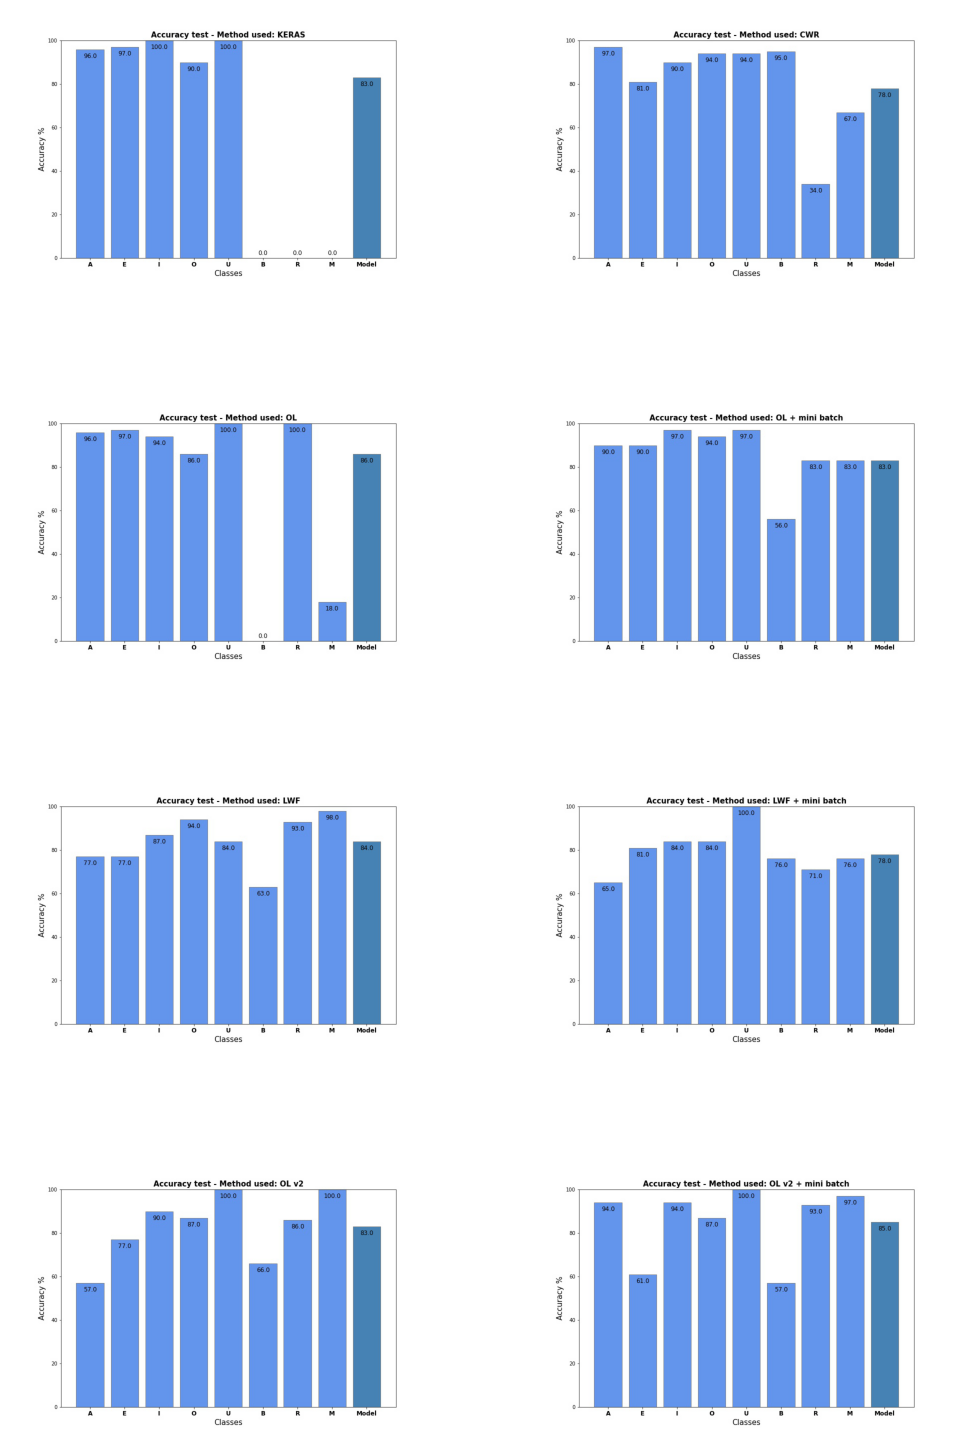

In [62]:
myBar.plot_barChart_All()

The following plot is a recap of all the methods trained. Note that it will be displayed only if all the training have been performed in this runtime. 
The table contains some additiona information and not only the accuracy.

In [63]:
if(KERAS and OL_vowels and OL and OL_mini and LWF and LWF_mini and OL_v2 and OL_v2_mini and CWR):
    
    myTable.table_simulationResult(Model_KERAS, Model_OL_vowels, Model_OL_all_mixed, Model_OL_mini, 
               Model_LWF_1, Model_LWF_2, Model_OL_v2, Model_OL_v2_miniBatch, Model_CWR)  

# GENERAL PLOTS

The block below is used for storing the result of the simulation formermed in this runtime. This is used for another plotting function that will display the average accuracy of each method across multiple runtimes.

In [64]:
# Write down in txt files all the results across 10 or so simulations          
WRITE_SIMU_RES = 0
                
if(WRITE_SIMU_RES==1):
    myWrite.save_simulationResult('Keras',     Model_KERAS)
    myWrite.save_simulationResult('OL_vowels', Model_OL_vowels)
    myWrite.save_simulationResult('OL',        Model_OL_all_mixed)
    myWrite.save_simulationResult('OL_mini',   Model_OL_mini)
    myWrite.save_simulationResult('LWF',       Model_LWF_1)
    myWrite.save_simulationResult('LWF_mini',  Model_LWF_2)
    myWrite.save_simulationResult('OL_v2',     Model_OL_v2)
    myWrite.save_simulationResult('OL_v2_min', Model_OL_v2_miniBatch)
    myWrite.save_simulationResult('CWR',       Model_CWR)

In [65]:
# Plot the average accuracy over several runtimes

#myBar.plot_barChart_SimuRes(1)

The block below plots some pie charts that shows how the dataset are composed.

In [66]:
ENABLE_PLOTS = 0
if(ENABLE_PLOTS==1):
    
    
    vowels_data_tf, vowels_label_tf = myParse.loadDataFromTxt('vowels_TF')
    TF_data_train, _, TF_data_test, _ = myParse.parseTrainTest(vowels_data_tf, vowels_label_tf, 0.7)


    # Plot of the pie chart of the dataset TF e OL
    dataset_shapes = np.zeros(8)
    label_vow = ['A','E','I','O','U']

    for i in range(0,vowels_data.shape[0]):
        for j in range(0,len(label_vow)):
            if(label_vow[j] == vowels_label[i]):
                dataset_shapes[j] += 1
                break
    for i in range(0,vowels_data_tf.shape[0]):
        for j in range(0,len(label_vow)):
            if(label_vow[j] == vowels_label_tf[i]):
                dataset_shapes[j] += 1
                break

    dataset_shapes[5] = B_data.shape[0]
    dataset_shapes[6] = R_data.shape[0]
    dataset_shapes[7] = M_data.shape[0]
    myPie.plot_pieChart_datasetAll(dataset_shapes)

    
    
    
    

    dataset_shapes = np.zeros([8])
    dataset_shapes[0] = OL_data_train_vow.shape[0]
    dataset_shapes[1] = OL_data_test_vow.shape[0]
    dataset_shapes[2] = B_train_data.shape[0]
    dataset_shapes[3] = B_test_data.shape[0]
    dataset_shapes[4] = R_train_data.shape[0]
    dataset_shapes[5] = R_test_data.shape[0]
    dataset_shapes[6] = M_train_data.shape[0]
    dataset_shapes[7] = M_test_data.shape[0]
    # Plot of the pie chart of the dataset OL
    myPie.plot_pieChart_DatasetOL(dataset_shapes)

    # Plot of the pie chart of the dataset TF
    myPie.plot_pieChart_DatasetTF(TF_data_train.shape[0],TF_data_test.shape[0])